<a href="https://colab.research.google.com/github/enakai00/rl_book_solutions/blob/master/Chapter04/Exercise_4_7_(Policy_Iteration)_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import poisson

from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

In [0]:
class CarRental:
  def __init__(self, size=20,
               fst_rent_mean=3, snd_rent_mean=4,
               fst_ret_mean=3, snd_ret_mean=2):
    self.size = size
    self.fst_rent_mean = fst_rent_mean
    self.snd_rent_mean = snd_rent_mean    
    self.fst_ret_mean = fst_ret_mean
    self.snd_ret_mean = snd_ret_mean       
    
    self.states = [(fst, snd) for fst in range(size+1) for snd in range(size+1)]
    self.value = {}
    self.policy = {} # Greedy policy
    
    # Initialize with 0 values
    for s in self.states:
      self.value[s] = 0
      
    # Initialize with policy of moving no cars
    for s in self.states:
      self.policy[s] = 0
      
  def show_value(self):
    value = np.zeros((self.size+1, self.size+1))
    for s in self.states:
      (fst, snd) = s
      value[fst][snd] = self.value[s]
      
    x = range(0, self.size+1)
    y = range(0, self.size+1)
    X, Y = np.meshgrid(x, y)
    Z = value[X, Y]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(X, Y, Z, color='gray')
    ax.set_xticks(range(0, self.size+1, 2))
    ax.set_yticks(range(0, self.size+1, 2))
    ax.set_xlabel('second')
    ax.set_ylabel('first')
    ax.set_zlabel('value')

  def show_policy(self):
    result = np.zeros((self.size+1, self.size+1))
    for s in self.states:
      (fst, snd) = s
      result[fst][snd] = self.policy[s]
    sns.heatmap(result, annot=True, cmap='seismic')

In [0]:
def memoize(f):
    cache = {}
    def helper(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    return helper

@memoize
def _poisson_pmf(n, mean):
  return poisson.pmf(n, mean)
  
@memoize
def poisson_pmf(n, n_max, mean):
  if n > n_max:
    return 0
  if n == n_max:
    return 1-sum([poisson.pmf(n, mean) for n in range(n_max)])
  return _poisson_pmf(n, mean)

In [0]:
def policy_eval(car_rental, gamma=0.9, theta=0.1):
  
  size = car_rental.size
  fst_rent_mean = car_rental.fst_rent_mean
  snd_rent_mean = car_rental.snd_rent_mean    
  fst_ret_mean = car_rental.fst_ret_mean
  snd_ret_mean = car_rental.snd_ret_mean  

  c = 0
  while True:
    deltas = []
    for s in car_rental.states:
      v = car_rental.value[s]
      (fst, snd) = s

      a = car_rental.policy[s]
      fst -= a # Moving cars
      snd += a # Moving cars

      v_new = 0
      # Loop for possible next states
      for fst_rent in range(fst+1):
        # Prob for fst_rent
        prob1 = poisson_pmf(fst_rent, fst, fst_rent_mean)
        
        for snd_rent in range(snd+1):
          # Prob for fst_rent * snd_rent
          prob2 = prob1 * poisson_pmf(snd_rent, snd, snd_rent_mean)
          r = -2 * abs(a) + 10 * (fst_rent + snd_rent)

          for fst_ret in range(size-(fst-fst_rent)+1):
            # Prob for fst_rent * snd_rent * fst_ret
            prob3 = prob2 * poisson_pmf(fst_ret, size-(fst-fst_rent), fst_ret_mean)
            
            for snd_ret in range(size-(snd-snd_rent)+1):
              # Prob for fst_rent * snd_rent * fst_ret * snd_ret
              prob = prob3 * poisson_pmf(snd_ret, size-(snd-snd_rent), snd_ret_mean)

              s_new = (fst - fst_rent + fst_ret, snd - snd_rent + snd_ret)
              v_new += prob * (r + gamma*car_rental.value[s_new])

      car_rental.value[s] = v_new
      deltas.append(abs(v-v_new))

    c += 1
    print ('End of iteration {}, delta={}'.format(c, max(deltas)))
    if max(deltas) < theta:
      break

In [0]:
def policy_update(car_rental, gamma=0.9):

  size = car_rental.size
  fst_rent_mean = car_rental.fst_rent_mean
  snd_rent_mean = car_rental.snd_rent_mean    
  fst_ret_mean = car_rental.fst_ret_mean
  snd_ret_mean = car_rental.snd_ret_mean  
  
  for s in car_rental.states:      
    q = {}

    # Search for argmax
    (_fst, _snd)  = s
    for a in range(-min(_snd, 5), min(_fst, 5)+1):
      q[a] = 0
      
      (fst, snd)  = s
      fst -= a # Moving cars
      snd += a # Moving cars

      # Loop for possible next states
      for fst_rent in range(fst+1):
        # Prob for fst_rent
        prob1 = poisson_pmf(fst_rent, fst, fst_rent_mean)
        
        for snd_rent in range(snd+1):
          # Prob for fst_rent * snd_rent
          prob2 = prob1 * poisson_pmf(snd_rent, snd, snd_rent_mean)
          r = -2 * abs(a) + 10 * (fst_rent + snd_rent)
          
          for fst_ret in range(size-(fst-fst_rent)+1):
            # Prob for fst_rent * snd_rent * fst_ret
            prob3 = prob2 * poisson_pmf(fst_ret, size-(fst-fst_rent), fst_ret_mean)
            
            for snd_ret in range(size-(snd-snd_rent)+1):
              # Prob for fst_rent * snd_rent * fst_ret * snd_ret
              prob = prob3 * poisson_pmf(snd_ret, size-(snd-snd_rent), snd_ret_mean)

              s_new = (fst - fst_rent + fst_ret, snd - snd_rent + snd_ret)
              q[a] += prob * (r + gamma*car_rental.value[s_new])

    car_rental.policy[s] = max(q, key=q.get)

In [0]:
car_rental = CarRental(size=20)

End of iteration 1, delta=193.34904927509487
End of iteration 2, delta=134.0042608644686
End of iteration 3, delta=90.45243773746216
End of iteration 4, delta=67.59779106615349
End of iteration 5, delta=53.58493061758037
End of iteration 6, delta=41.72086291128437
End of iteration 7, delta=32.72010939685663
End of iteration 8, delta=26.087556138173852
End of iteration 9, delta=21.778143392698723
End of iteration 10, delta=18.318059790333166
End of iteration 11, delta=15.367406347700467
End of iteration 12, delta=12.861027123615884
End of iteration 13, delta=10.739286690814708
End of iteration 14, delta=8.94900414527234
End of iteration 15, delta=7.443128433756158
End of iteration 16, delta=6.180206266077221
End of iteration 17, delta=5.123897292162155
End of iteration 18, delta=4.242540347244528
End of iteration 19, delta=3.508736868355413
End of iteration 20, delta=2.8989345554258534
End of iteration 21, delta=2.393012044082411
End of iteration 22, delta=1.9738735796697142
End of iter

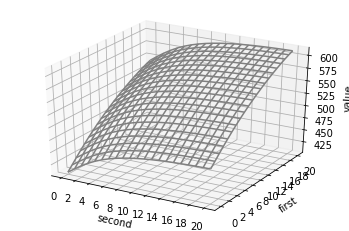

In [7]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 1min 58s, sys: 201 ms, total: 1min 58s
Wall time: 1min 58s


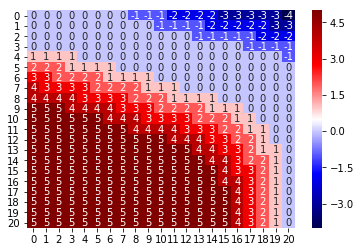

In [8]:
%%time
policy_update(car_rental)
car_rental.show_policy()

End of iteration 1, delta=64.5759522683951
End of iteration 2, delta=4.872618926687437
End of iteration 3, delta=2.166194922957743
End of iteration 4, delta=1.5734951228207024
End of iteration 5, delta=1.3649912313739492
End of iteration 6, delta=1.1331455203079486
End of iteration 7, delta=0.9302166382132668
End of iteration 8, delta=0.7619361629434707
End of iteration 9, delta=0.6237889096314575
End of iteration 10, delta=0.5106062561908971
End of iteration 11, delta=0.4179307040606659
End of iteration 12, delta=0.34206453760538125
End of iteration 13, delta=0.27996551016832427
End of iteration 14, delta=0.22913793765860646
End of iteration 15, delta=0.18753705155825173
End of iteration 16, delta=0.15348843831247905
End of iteration 17, delta=0.12562129627485774
End of iteration 18, delta=0.10281351785664583
End of iteration 19, delta=0.08414662965356001
CPU times: user 4min 29s, sys: 111 ms, total: 4min 29s
Wall time: 4min 30s


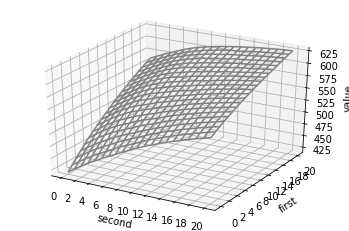

In [9]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 23s, sys: 206 ms, total: 2min 23s
Wall time: 2min 23s


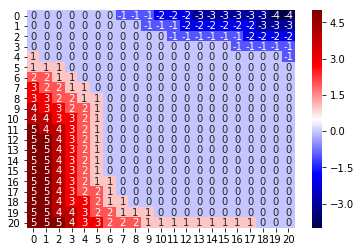

In [10]:
%%time
policy_update(car_rental)
car_rental.show_policy()

End of iteration 1, delta=4.27633017555695
End of iteration 2, delta=2.84408456961512
End of iteration 3, delta=1.9593362073587741
End of iteration 4, delta=1.4157966909014021
End of iteration 5, delta=0.9785748856839973
End of iteration 6, delta=0.6582181960576463
End of iteration 7, delta=0.4416691494927818
End of iteration 8, delta=0.30159235758083014
End of iteration 9, delta=0.224062416573247
End of iteration 10, delta=0.17197218992714625
End of iteration 11, delta=0.1365943167593855
End of iteration 12, delta=0.1122281229737041
End of iteration 13, delta=0.09209736688472958
CPU times: user 3min 6s, sys: 104 ms, total: 3min 6s
Wall time: 3min 6s


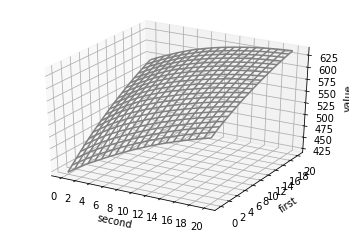

In [11]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 27s, sys: 189 ms, total: 2min 27s
Wall time: 2min 27s


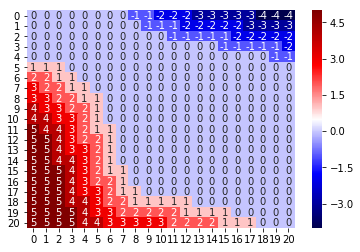

In [12]:
%%time
policy_update(car_rental)
car_rental.show_policy()

End of iteration 1, delta=0.5438356733975525
End of iteration 2, delta=0.19512004275429717
End of iteration 3, delta=0.10684838360168669
End of iteration 4, delta=0.07076254363050793
CPU times: user 56.9 s, sys: 83.9 ms, total: 57 s
Wall time: 57 s


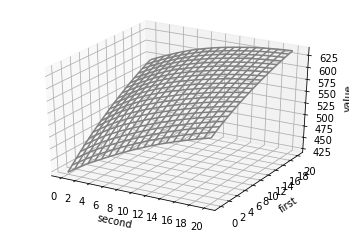

In [13]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 26s, sys: 214 ms, total: 2min 26s
Wall time: 2min 26s


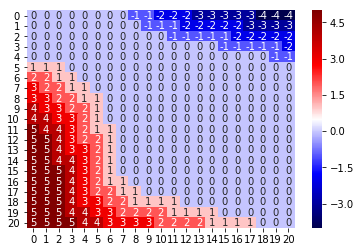

In [14]:
%%time
policy_update(car_rental)
car_rental.show_policy()